In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="viridis")

import folium
from folium.plugins import HeatMap
from IPython.display import IFrame
reports_path = Path.cwd().parent / "reports"

sys.path.append(str(Path().resolve().parent / "src"))
from utils import load_all_csvs
from sanitize import sanitize_all
from aggregations import (
    exam_volume_by_zip,
    avg_cost_by_zip,
    exam_volume_by_age_group,
    top_coditems,
    add_age_column
)
from viz_aggregations import (
    plot_exam_volume_by_zip,
    plot_avg_cost_by_zip,
    plot_exam_volume_by_age_group,
    plot_top_coditems
)
from viz_map import generate_exam_location_map

In [2]:
dfs = load_all_csvs(Path.cwd().parent / "data")
dfs = sanitize_all(dfs)

In [3]:
for name in dfs:
    dfs[name] = dfs[name].loc[:, ~dfs[name].columns.str.startswith('Unnamed')]

In [4]:
def plot_numeric_distributions(dfs: dict[str, pd.DataFrame], max_cols: int = 2, bins: int = 50):
    ignore_keywords = ['id', 'zipcode', 'coditem', 'zip', 'lab']

    for name, df in dfs.items():
        num_df = df.select_dtypes(include='number')
        cols_to_plot = [col for col in num_df.columns if not any(k in col.lower() for k in ignore_keywords)]
        if not cols_to_plot:
            continue

        print(f"\n📊 Distribuições numéricas – {name}")
        n_cols = len(cols_to_plot)
        n_rows = (n_cols + max_cols - 1) // max_cols

        fig, axes = plt.subplots(n_rows * 2, max_cols, figsize=(6 * max_cols, 2.5 * n_rows * 2))
        axes = axes.flatten()

        for i, col in enumerate(cols_to_plot):
            hist_ax = axes[2 * i]
            box_ax = axes[2 * i + 1]

            sns.histplot(data=df, x=col, bins=bins, ax=hist_ax, kde=True)
            hist_ax.set_title(f"{col} – Histograma")
            hist_ax.set_xlabel("")
            hist_ax.set_ylabel("")

            sns.boxplot(data=df, x=col, ax=box_ax, orient='h')
            box_ax.set_title(f"{col} – Boxplot")
            box_ax.set_xlabel("")

        # Esconde eixos não usados (caso ímpar)
        for j in range(2 * len(cols_to_plot), len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()


📊 Distribuições numéricas – exams


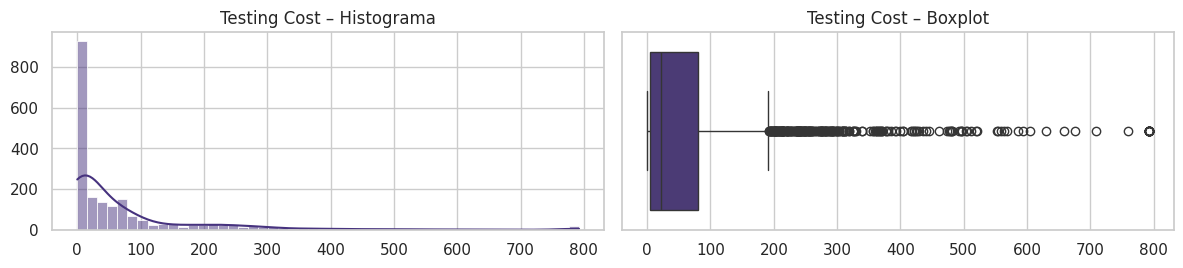


📊 Distribuições numéricas – demographic


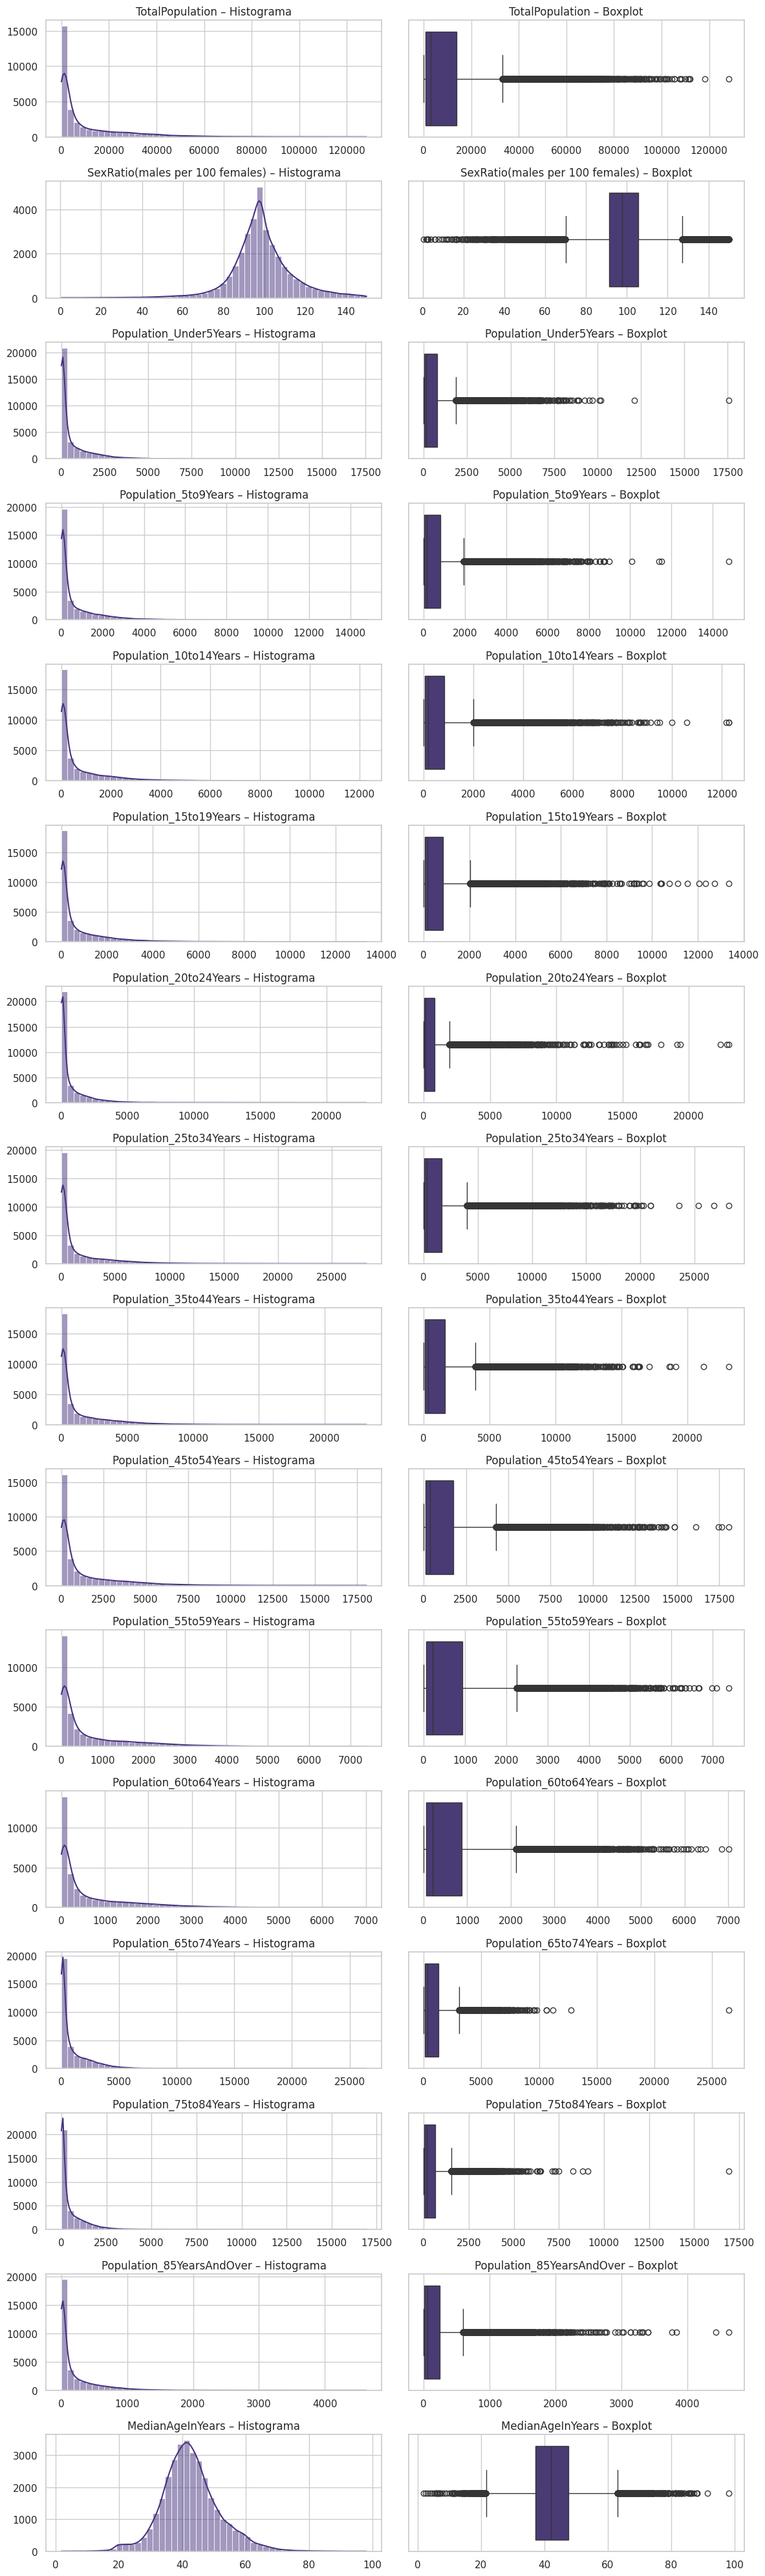


📊 Distribuições numéricas – transactional


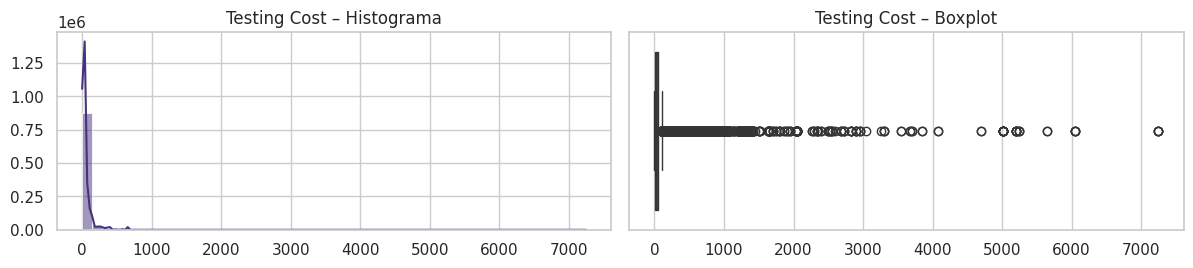


📊 Distribuições numéricas – economic


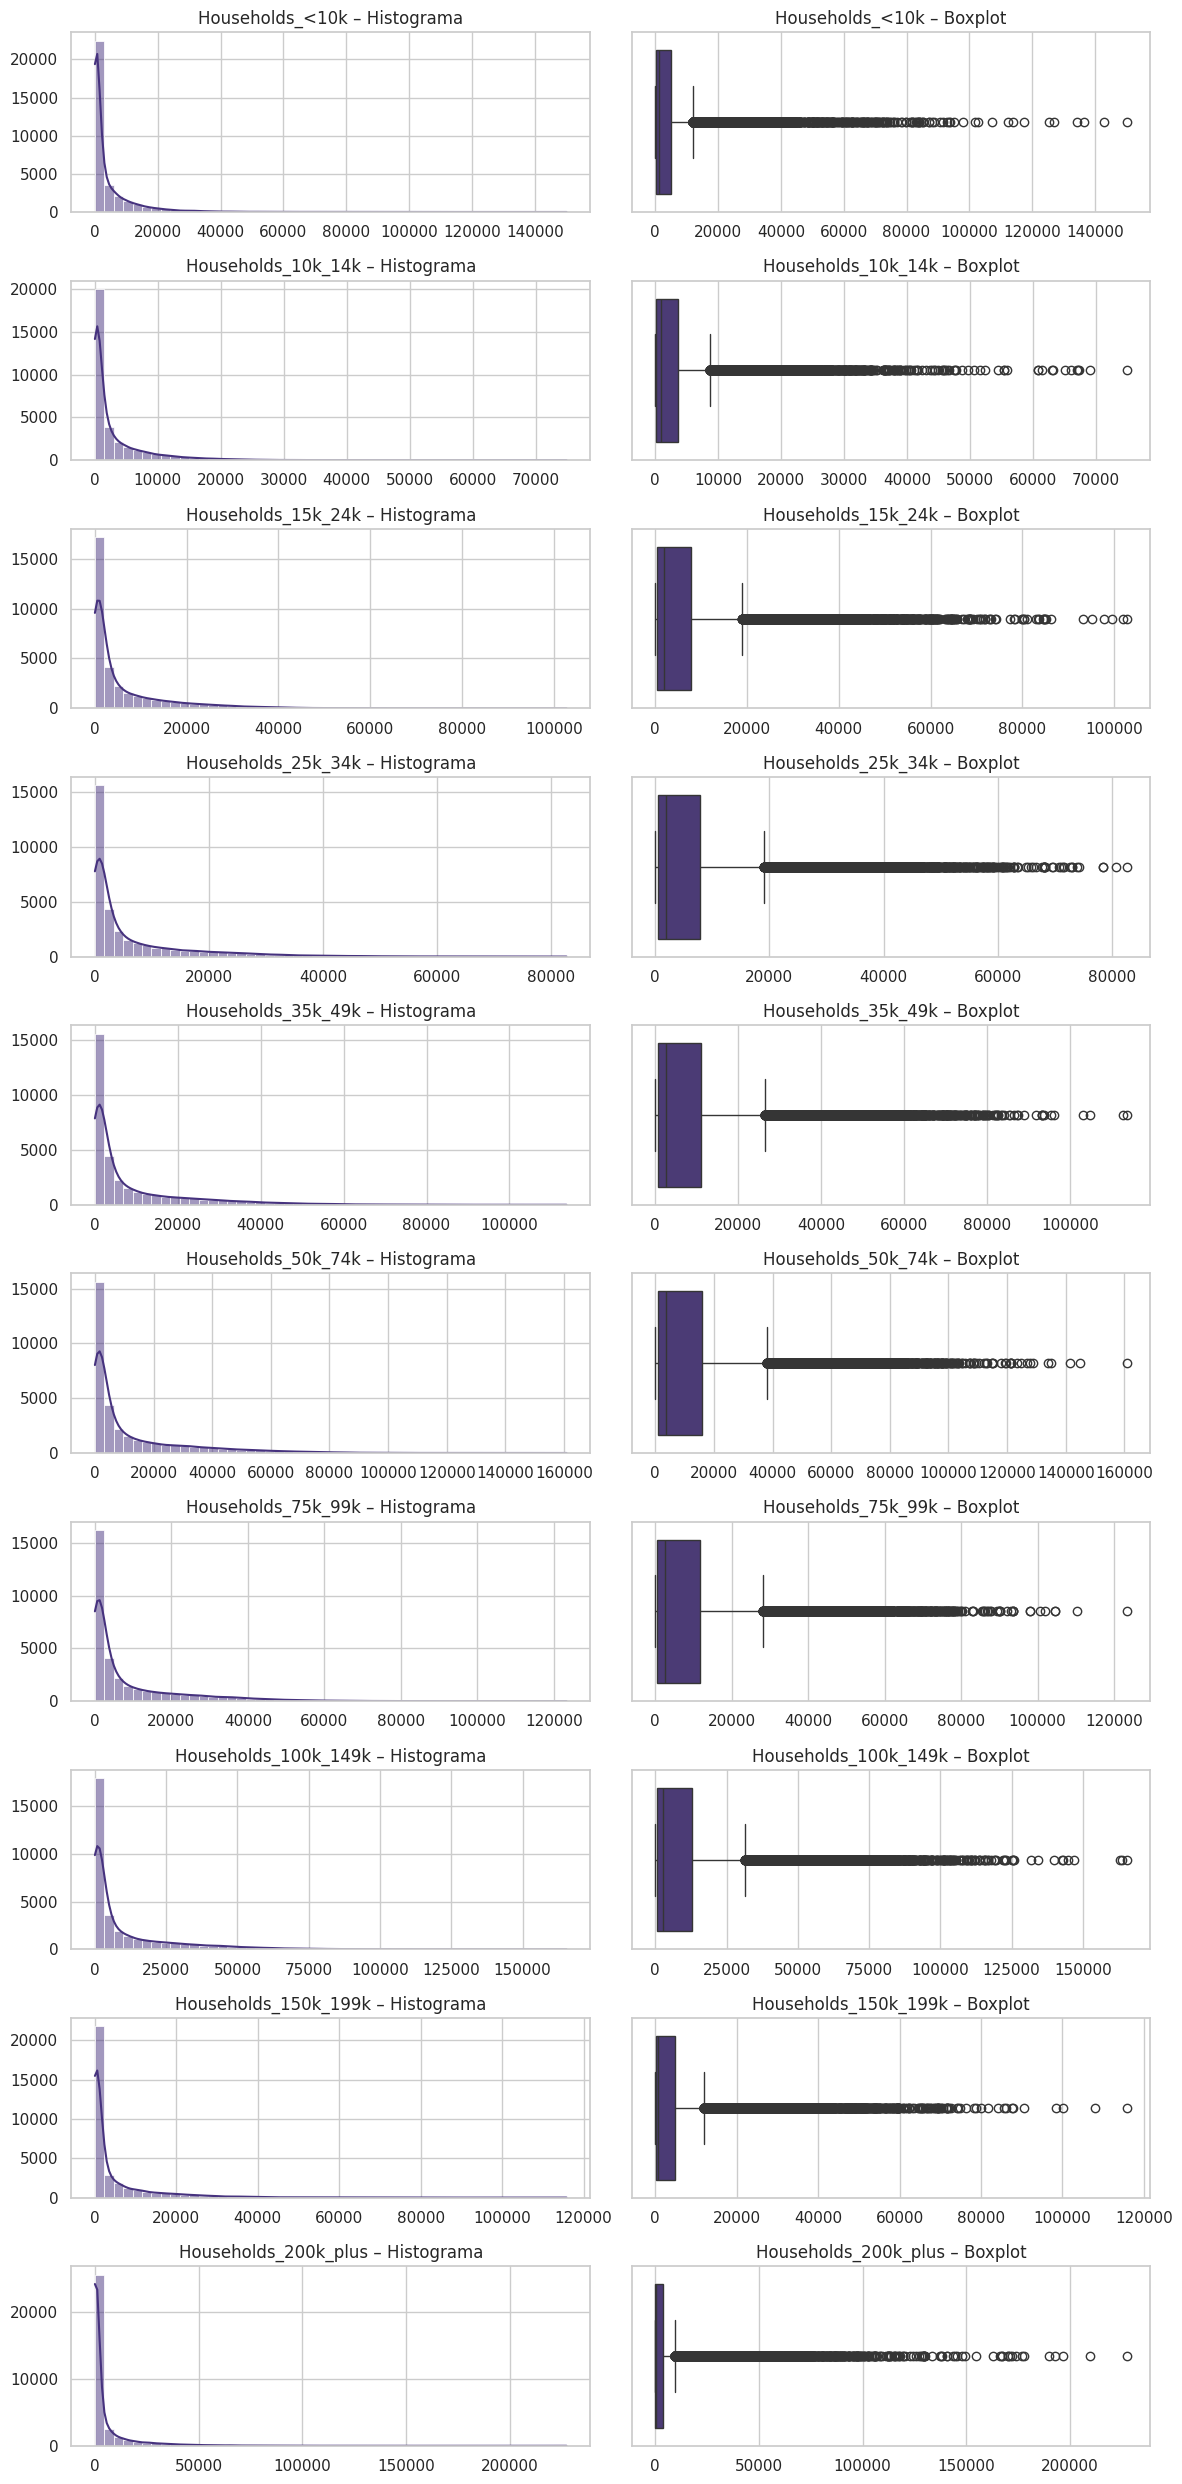

In [5]:
plot_numeric_distributions(dfs)

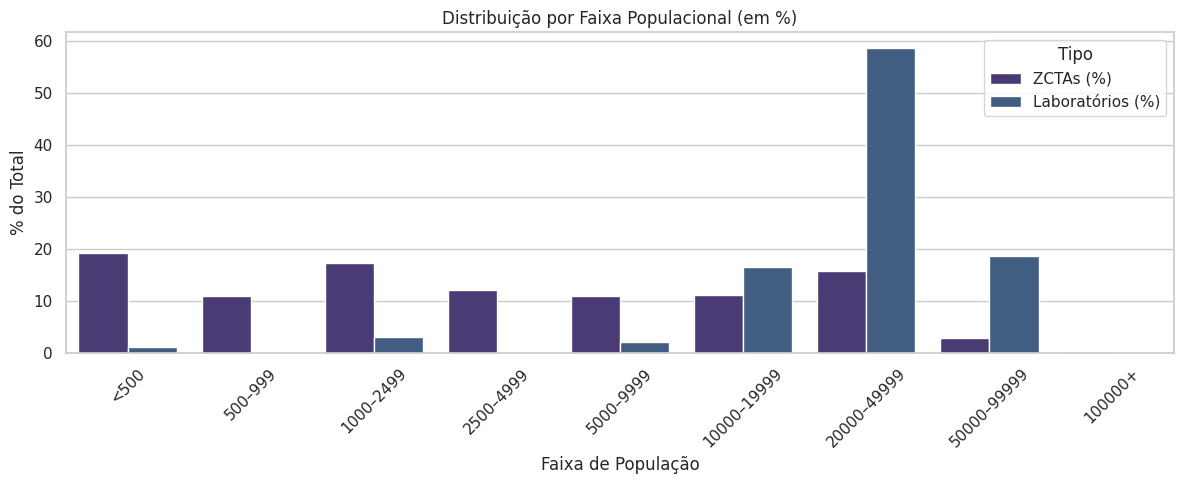

,Faixa Populacional,ZCTAs (%),Laboratórios (%)
0,<500,19.13,1.03
1,500–999,10.99,0.00
2,1000–2499,17.30,3.09
3,2500–4999,12.05,0.00
4,5000–9999,10.85,2.06
5,10000–19999,11.16,16.49
6,20000–49999,15.65,58.76
7,50000–99999,2.81,18.56
8,100000+,0.05,0.00


In [6]:
def plot_population_and_lab_distribution(
    demographic_df: pd.DataFrame,
    geocode_df: pd.DataFrame,
    bins=None,
    labels=None,
    use_percentage: bool = True
):
    """
    Plota com Seaborn a distribuição por faixa populacional:
    - ZCTAs gerais (dados demográficos)
    - Laboratórios (a partir do ZIP/ZCTA)

    Parâmetros:
    - use_percentage: Se True, plota em % em vez de contagem absoluta
    """
    # Faixas padrão
    if bins is None:
        bins = [0, 500, 1000, 2500, 5000, 10000, 20000, 50000, 100000, float('inf')]
    if labels is None:
        labels = ['<500', '500–999', '1000–2499', '2500–4999', '5000–9999',
                  '10000–19999', '20000–49999', '50000–99999', '100000+']

    # Preparar cópias dos dados
    demographic_df = demographic_df.copy()
    geocode_df = geocode_df.copy()

    # Classificação por faixa
    demographic_df['PopulationGroup'] = pd.cut(demographic_df['TotalPopulation'], bins=bins, labels=labels, right=False)
    demographic_df['ZCTA'] = demographic_df['GeographicAreaName'].str.extract(r'ZCTA5 (\d{5})')
    geocode_df['Zipcode'] = geocode_df['Zipcode'].astype(str).str.split('.').str[0]

    # Merge laboratórios + dados populacionais
    merged = geocode_df.merge(
        demographic_df[['ZCTA', 'TotalPopulation', 'PopulationGroup']],
        left_on='Zipcode', right_on='ZCTA', how='left'
    )

    # Contagens por faixa
    zcta_counts = demographic_df['PopulationGroup'].value_counts().sort_index()
    lab_counts = merged['PopulationGroup'].value_counts().sort_index()

    if use_percentage:
        zcta_counts = (zcta_counts / zcta_counts.sum() * 100).round(2)
        lab_counts = (lab_counts / lab_counts.sum() * 100).round(2)

    # Organizar DataFrame para visualização
    plot_df = pd.DataFrame({
        'Faixa Populacional': labels,
        'ZCTAs (%)' if use_percentage else 'ZCTAs': zcta_counts.reindex(labels).fillna(0).values,
        'Laboratórios (%)' if use_percentage else 'Laboratórios': lab_counts.reindex(labels).fillna(0).values
    })

    plot_df_melted = plot_df.melt(id_vars='Faixa Populacional', var_name='Tipo', value_name='Valor')

    # Plot com Seaborn
    plt.figure(figsize=(12, 5))
    sns.barplot(data=plot_df_melted, x='Faixa Populacional', y='Valor', hue='Tipo')
    plt.title("Distribuição por Faixa Populacional" + (" (em %)" if use_percentage else ""))
    plt.xlabel("Faixa de População")
    plt.ylabel("% do Total" if use_percentage else "Contagem")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return plot_df


plot_population_and_lab_distribution(dfs['demographic'], dfs['geocode'])


Distribuições numéricas – exams (pop > 10000)


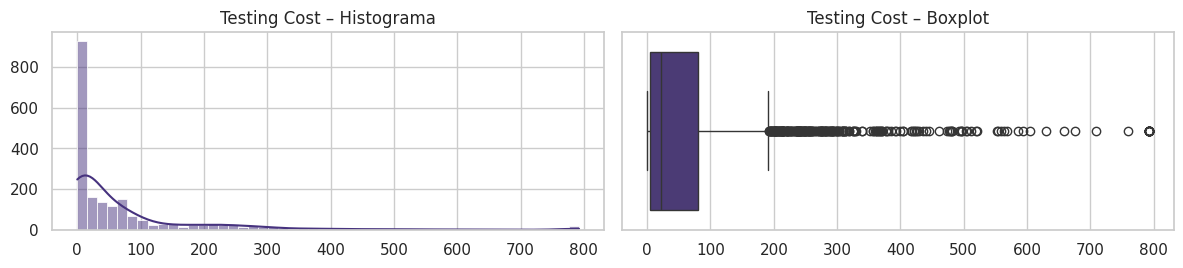


Distribuições numéricas – demographic (pop > 10000)


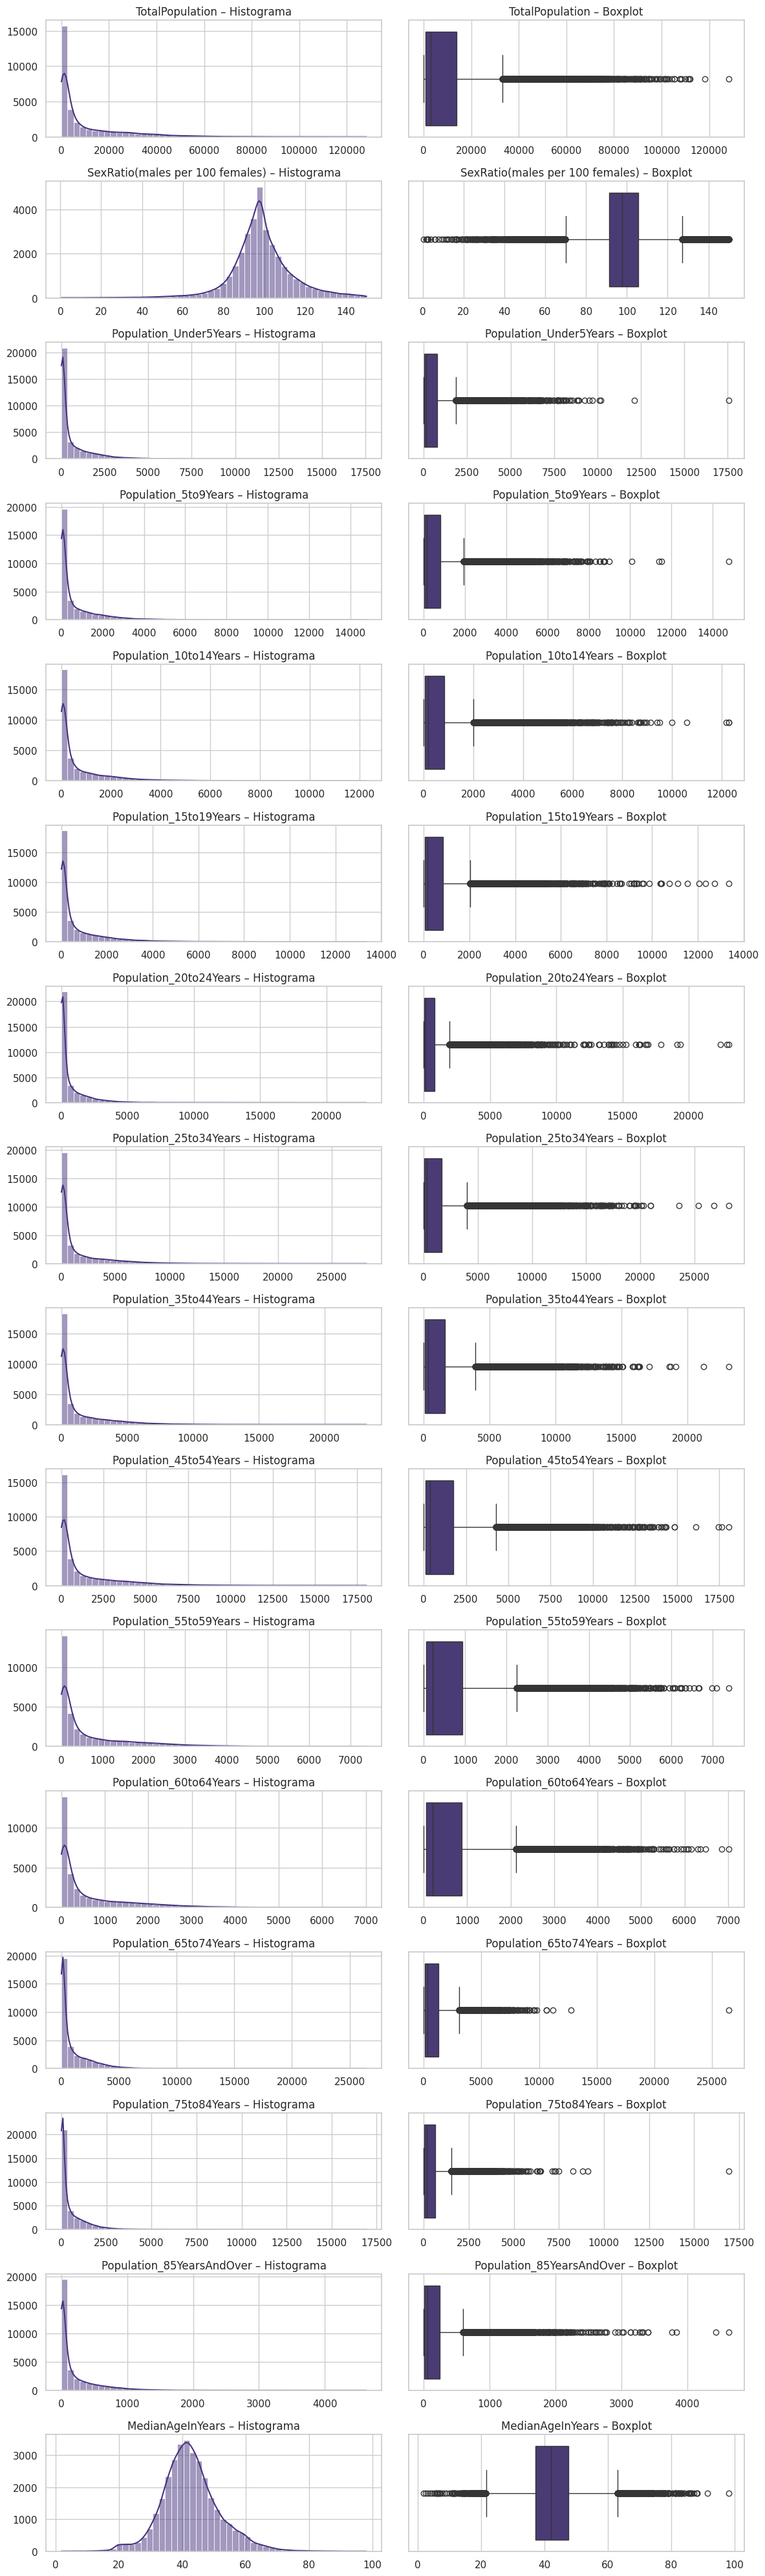


Distribuições numéricas – transactional (pop > 10000)


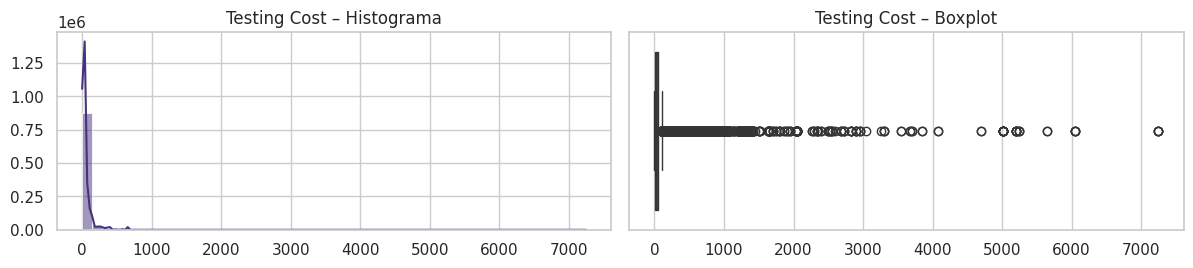


Distribuições numéricas – economic (pop > 10000)


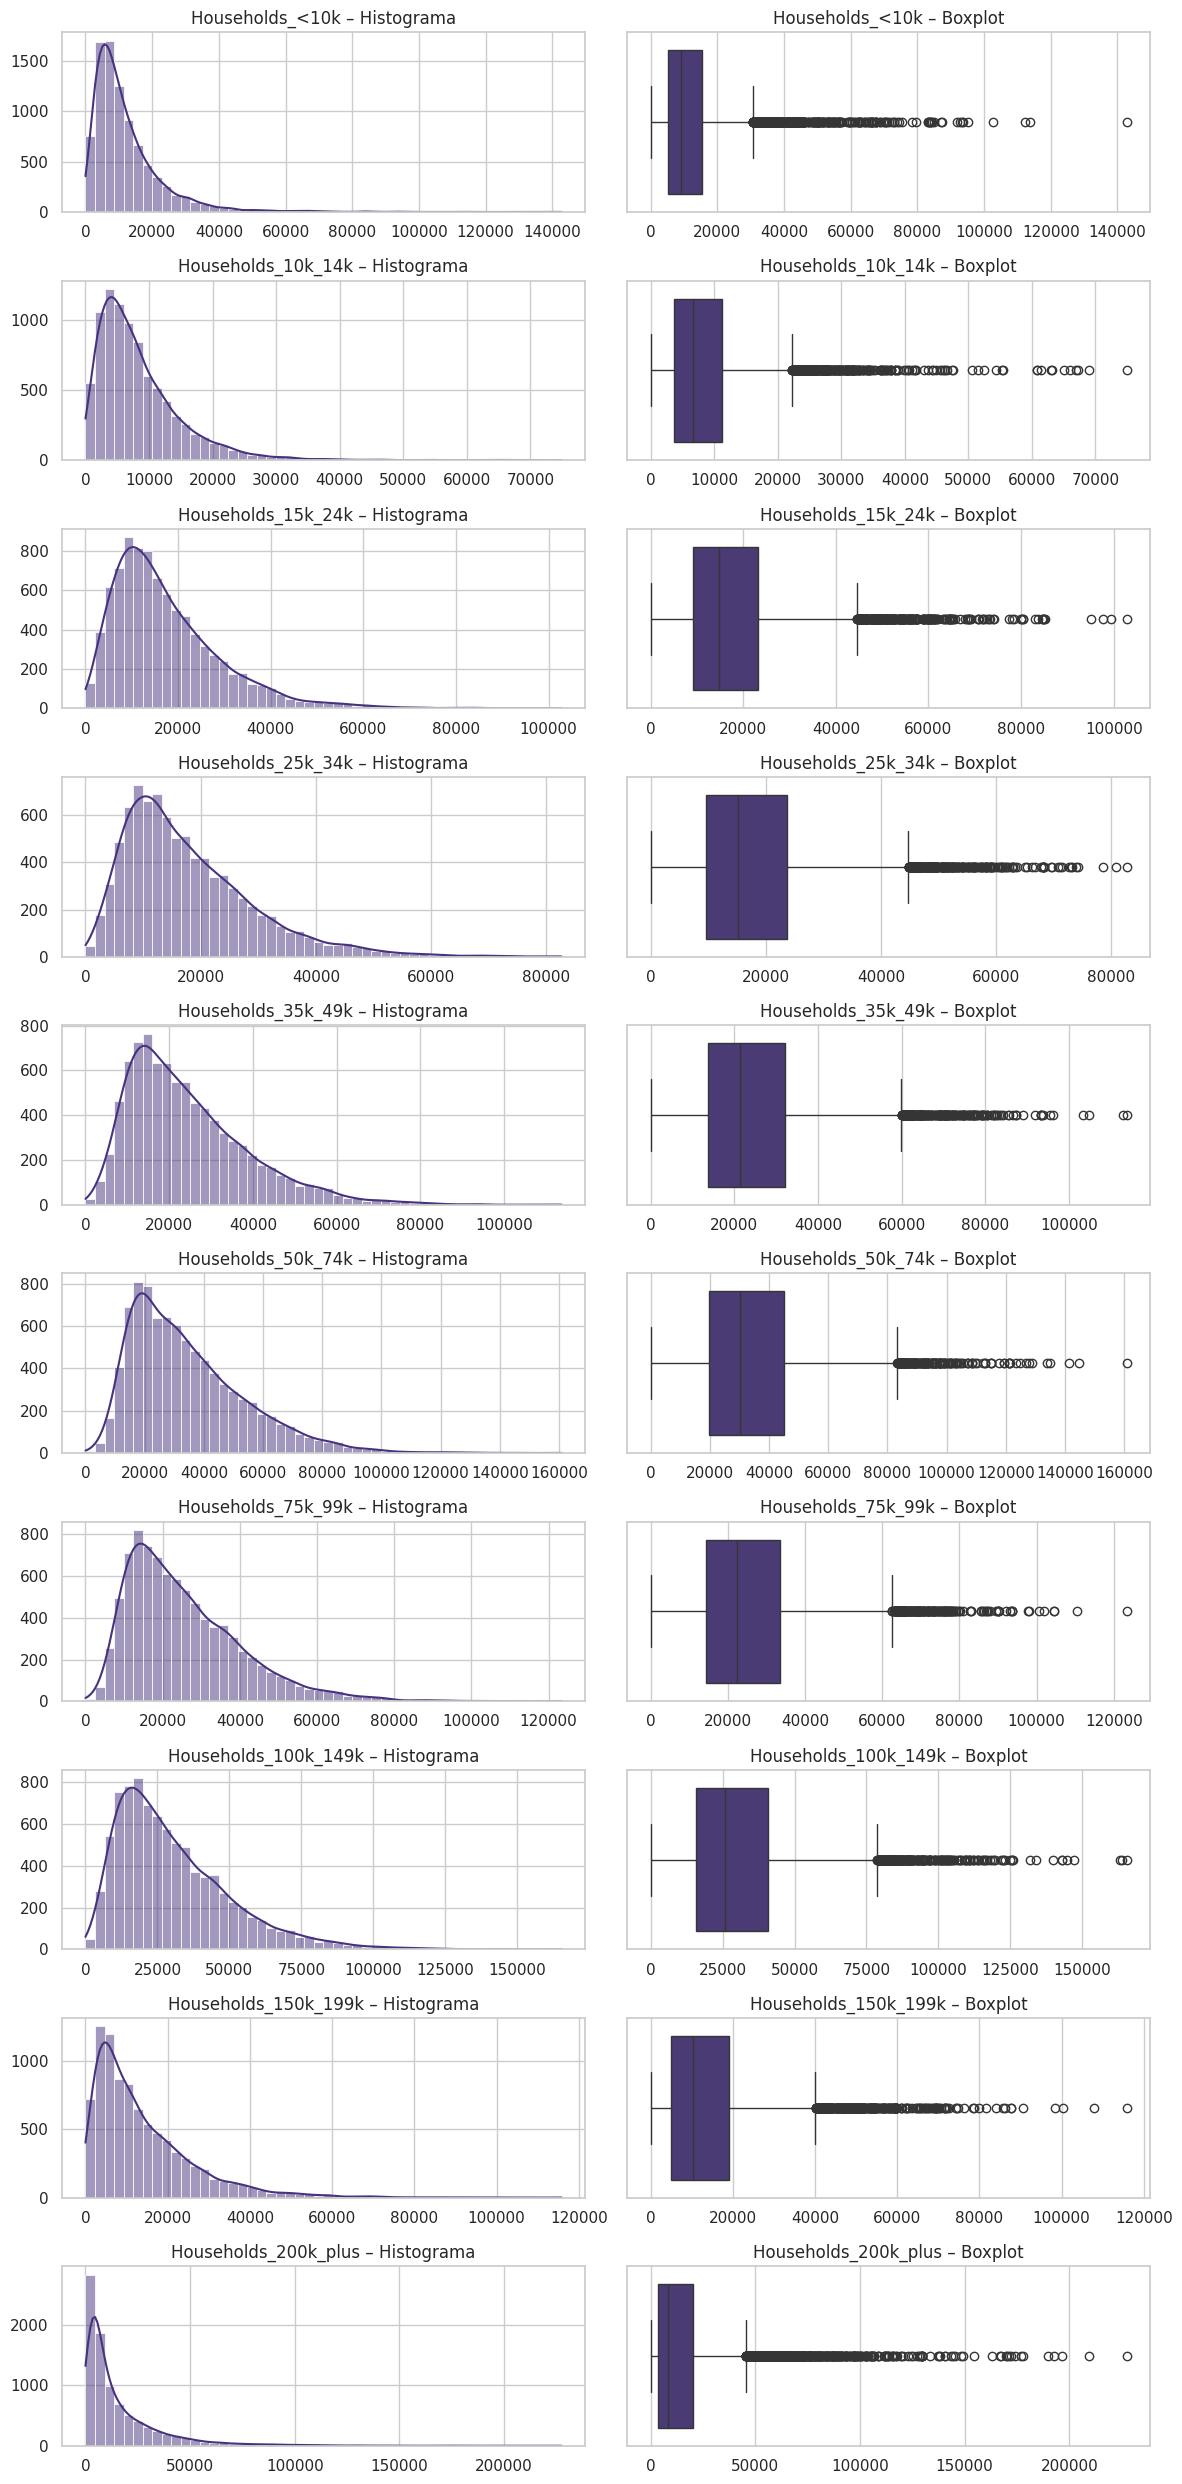

In [7]:
def plot_numeric_distributions(
    dfs: dict[str, pd.DataFrame],
    zcta_population: pd.DataFrame | None = None,
    min_population: int = None,
    max_cols: int = 2,
    bins: int = 50
):
    ignore_keywords = ['id', 'zipcode', 'coditem', 'zip', 'lab']

    for name, df in dfs.items():
        df_filtered = df.copy()

        # Aplicar filtro de população se for passado
        if zcta_population is not None and min_population is not None:
            if 'Zipcode' in df.columns:
                # Normaliza e junta pelo Zipcode
                df['Zipcode'] = df['Zipcode'].astype(str).str.split('.').str[0]
                zcta_population['ZCTA'] = zcta_population['GeographicAreaName'].str.extract(r'ZCTA5 (\d{5})')
                pop_map = zcta_population.set_index('ZCTA')['TotalPopulation'].astype(float)
                df_filtered = df[df['Zipcode'].astype(str).map(pop_map) > min_population]

                if df_filtered.empty:
                    print(f"\nNenhum dado com população > {min_population} em {name}")
                    continue

        # Seleciona colunas numéricas excluindo identificadores
        num_df = df_filtered.select_dtypes(include='number')
        cols_to_plot = [col for col in num_df.columns if not any(k in col.lower() for k in ignore_keywords)]
        if not cols_to_plot:
            continue

        print(f"\nDistribuições numéricas – {name} (pop > {min_population})")
        n_cols = len(cols_to_plot)
        n_rows = (n_cols + max_cols - 1) // max_cols

        fig, axes = plt.subplots(n_rows * 2, max_cols, figsize=(6 * max_cols, 2.5 * n_rows * 2))
        axes = axes.flatten()

        for i, col in enumerate(cols_to_plot):
            hist_ax = axes[2 * i]
            box_ax = axes[2 * i + 1]

            sns.histplot(data=df_filtered, x=col, bins=bins, ax=hist_ax, kde=True)
            hist_ax.set_title(f"{col} – Histograma")
            hist_ax.set_xlabel("")
            hist_ax.set_ylabel("")

            sns.boxplot(data=df_filtered, x=col, ax=box_ax, orient='h')
            box_ax.set_title(f"{col} – Boxplot")
            box_ax.set_xlabel("")

        for j in range(2 * len(cols_to_plot), len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()
plot_numeric_distributions(dfs, zcta_population=dfs['demographic'], min_population=10_000)

In [8]:
demographic_df = dfs['demographic']
demographic_df.head()

,Id,GeographicAreaName,TotalPopulation,SexRatio(males per 100 females),Population_Under5Years,Population_5to9Years,Population_10to14Years,Population_15to19Years,Population_20to24Years,Population_25to34Years,Population_35to44Years,Population_45to54Years,Population_55to59Years,Population_60to64Years,Population_65to74Years,Population_75to84Years,Population_85YearsAndOver,MedianAgeInYears,ZCTA
0,8600000US35004,ZCTA5 35004,12045,94.1,805,1075,898,477,578,2088,1628,1200,886,683,1017,534,176,35.5,35004
1,8600000US35005,ZCTA5 35005,7344,86.1,504,453,511,499,214,788,795,968,612,561,798,485,156,44.0,35005
2,8600000US35006,ZCTA5 35006,2883,108.2,96,153,303,129,156,183,367,430,296,260,280,201,29,47.2,35006
3,8600000US35007,ZCTA5 35007,26332,95.0,1936,1992,1837,1762,1376,3119,3849,3907,1665,1323,2096,1106,364,37.7,35007
4,8600000US35010,ZCTA5 35010,20613,90.5,1306,1465,944,1217,1128,2513,2106,2950,1512,1472,2421,1155,424,42.6,35010


In [9]:
## Se não tem o arquivo zcta_subset.geojson nas pasta Data
## Execute o seguinte comando
# !uv run ../src/geo_utils.py

In [10]:
def classificar_faixa_etaria(row):
    try:
        idade_mediana = float(row['MedianAgeInYears'])
        total_pop = float(row['TotalPopulation'])

        if pd.isna(idade_mediana) or pd.isna(total_pop) or total_pop == 0:
            return 'normal'  # evita erro ou divisão por zero

        pop_65 = float(row['Population_65to74Years'])
        pop_75 = float(row['Population_75to84Years'])
        pop_85 = float(row['Population_85YearsAndOver'])
        pop_under5 = float(row['Population_Under5Years'])

        perc_idosos = (pop_65 + pop_75 + pop_85) / total_pop
        perc_jovem = pop_under5 / total_pop

        if idade_mediana > 47 or perc_idosos > 0.25:
            return 'idosa'
        elif idade_mediana < 32 or perc_jovem > 0.10:
            return 'jovem'
        else:
            return 'normal'
    except Exception as e:
        return 'normal'

numeric_cols = [
    'TotalPopulation', 'MedianAgeInYears',
    'Population_65to74Years', 'Population_75to84Years',
    'Population_85YearsAndOver', 'Population_Under5Years'
]

for col in numeric_cols:
    demographic_df[col] = pd.to_numeric(demographic_df[col], errors='coerce')

# Aplica a classificação
demographic_df['faixa_etaria_classe'] = demographic_df.apply(classificar_faixa_etaria, axis=1)

# Verifica se funcionou
print(demographic_df['faixa_etaria_classe'].value_counts())

faixa_etaria_classe
normal    19508
idosa      9581
jovem      3687
Name: count, dtype: int64


In [11]:
zcta_gdf = gpd.read_file("../data/zcta_subset.geojson")

# Junta com seu dataframe demográfico
demographic_df['ZCTA'] = demographic_df['GeographicAreaName'].str.extract(r'ZCTA5 (\d{5})')
merged_gdf = zcta_gdf.merge(demographic_df, left_on='ZCTA5CE20', right_on='ZCTA', how='inner')

In [12]:
mapping = {'jovem': 0, 'normal': 1, 'idosa': 2}
merged_gdf['classe_num'] = merged_gdf['faixa_etaria_classe'].map(mapping)

In [13]:
import folium

# Centro aproximado do mapa
m = folium.Map(location=[39.5, -98.35], zoom_start=4)

# Adiciona polígonos coloridos por classe etária, por exemplo
folium.Choropleth(
    geo_data=zcta_gdf.to_json(),
    name='ZCTA por faixa etária',
    data=merged_gdf,
    columns=['ZCTA', 'classe_num'],
    key_on='feature.properties.ZCTA5CE20',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Faixa Etária (0=jovem, 1=normal, 2=idosa)'
).add_to(m)

# Exibe
m.save("../reports/map.html")


In [14]:
IFrame('../reports/map.html', width=900, height=600)

In [15]:
geocode_df = dfs['geocode']

# Garante que os códigos são strings
geocode_df['Zipcode'] = geocode_df['Zipcode'].astype(str).str.split('.').str[0]

# Conta quantos labs existem por ZCTA
labs_por_zcta = geocode_df.groupby('Zipcode')['Lab Id'].nunique().reset_index(name='num_labs')

# Verifica ZCTAs com mais de um laboratório
zcta_com_mais_de_um = labs_por_zcta[labs_por_zcta['num_labs'] > 1]

# Exibe
print(f"\nZCTAs com mais de um laboratório: {len(zcta_com_mais_de_um)}")
zcta_com_mais_de_um


ZCTAs com mais de um laboratório: 11


,Zipcode,num_labs
5,13413,2
29,19148,2
52,30342,2
55,3087,2
78,94520,3
84,94566,2
85,94583,2
90,98004,2
95,98034,3
98,98104,2


In [16]:
transactional = dfs['transactional']
geocode = dfs['geocode']

# Exam volume by ZCTA
# volume_zip = exam_volume_by_zip(transactional, geocode)
# plot_exam_volume_by_zip(volume_zip)

# Average testing cost by ZCTA
# custo_zip = avg_cost_by_zip(transactional, geocode)
# plot_avg_cost_by_zip(custo_zip)

# Exam volume by age group
# transactional = add_age_column(transactional)
# volume_faixa = exam_volume_by_age_group(transactional)
# plot_exam_volume_by_age_group(volume_faixa)

# Top CodItems by volume and total cost
# top_cod = top_coditems(transactional)
# plot_top_coditems(top_cod)


In [17]:
generate_exam_location_map(transactional, geocode, "../reports/exames_por_local.html")

✅ Mapa salvo em: ../reports/exames_por_local.html


In [18]:
IFrame('../reports/exames_por_local.html', width=900, height=600)